num_classes : 10
classe_names : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Device:  cpu


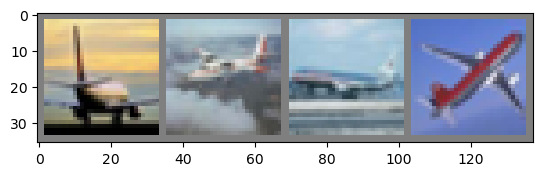

GroundTruth:  airplane airplane airplane airplane
Predicted:  automobile ship  ship  airplane
Accuracy of the network on the 10000 test images: 10 %
Recall for class: airplane is 58.6 %
Recall for class: automobile is 72.9 %
Recall for class: bird  is 38.3 %
Recall for class: cat   is 44.3 %
Recall for class: deer  is 42.0 %
Recall for class: dog   is 48.2 %
Recall for class: frog  is 73.9 %
Recall for class: horse is 45.7 %
Recall for class: ship  is 76.5 %
Recall for class: truck is 52.4 %


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from customdataset import CustomImageDataset

transform = transforms.Compose(
    [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

data_path = "./dataset"
train_data_set = CustomImageDataset(data_set_path=f"{data_path}/train",
                                    transforms=transform)
trainloader = torch.utils.data.DataLoader(train_data_set, batch_size=batch_size, shuffle=True)

test_data_set = CustomImageDataset(data_set_path=f"{data_path}/test",
                                    transforms=transform)
testloader = torch.utils.data.DataLoader(test_data_set, batch_size=batch_size, shuffle=False)

num_classes = train_data_set.num_classes
classes = train_data_set.class_names

print("num_classes :", num_classes)
print("classe_names :", classes)

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3) ## 채널의 수가 노드의 수와 같다 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net().to(device)

PATH = './cifar_net.pth'
net.load_state_dict(torch.load(PATH))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

correct = 0
total = 0

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    recall = 100 * float(correct_count) / total_pred[classname]
    print(f'Recall for class: {classname:5s} is {recall:.1f} %')

del dataiter